# Import librairies

In [1]:
import findspark
findspark.init()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, split, udf, pandas_udf, PandasUDFType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml import Pipeline

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

2022-01-20 12:26:52.762455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 12:26:52.762514: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load images

In [2]:
# Setting pyspark environment
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell'

In [3]:
# spark configuration
conf = SparkConf().set('spark.executor.extraJavaOptions','-Dcom.amazonaws.services.s3.enableV4=true'). \
    set('spark.driver.extraJavaOptions','-Dcom.amazonaws.services.s3.enableV4=true'). \
    setAppName('pyspark_aws').setMaster('local[*]')

In [4]:
# Setting up SparkContext
sc=SparkContext(conf=conf)
sc.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')

Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
com.amazonaws#aws-java-sdk-pom added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-03643b94-4504-4cb7-be4a-e2663368dcdc;1.0
	confs: [default]
	found com.amazonaws#aws-java-sdk-pom;1.10.34 in central
	found org.apache.hadoop#hadoop-aws;2.7.2 in central
	found org.apache.hadoop#hadoop-common;2.7.2 in central
	found org.apache.hadoop#hadoop-annotations;2.7.2 in central
	found com.google.guava#guava;11.0.2 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found commons-cli#commons-cli;1.2 in central
	found org.apache.commons#commons-math3;3.1.1 in central
	found xmlenc#xmlenc;0.52 in central
	found commons-httpclient#commons-httpclient;3.1 in central
	found commons

In [5]:
# Key to access S3

accessKeyId=os.environ['accessKeyId']
secretAccessKey=os.environ['secretAccessKey']

In [6]:
# hadoop configuration
hadoopConf = sc._jsc.hadoopConfiguration()
hadoopConf.set('fs.s3a.access.key', accessKeyId)
hadoopConf.set('fs.s3a.secret.key', secretAccessKey)
hadoopConf.set('fs.s3a.endpoint', 's3-us-west-1.amazonaws.com')
hadoopConf.set('fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')

In [7]:
# spark session
spark=SparkSession(sc)
spark

In [8]:
# import image from the S3 bucket
s3_url = "s3a://ah-oc-p8-images/samples/*"
df_image = spark.read.format("binaryFile").load(s3_url)

In [9]:
df_image.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [10]:
# display data loaded with spark
df_image.select("path", "content").show()

+--------------------+--------------------+
|                path|             content|
+--------------------+--------------------+
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|[FF D8 FF 

# Explore data

In [11]:
# add label of the images in the dataframe
df_image = df_image.withColumn('label', split(col('path'), '/').getItem(4))

In [12]:
# display the dataframe with label
df_image.select("path", "label", "content").show()

+--------------------+----------+--------------------+
|                path|     label|             content|
+--------------------+----------+--------------------+
|s3a://ah-oc-p8-im...|Cantaloupe|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|Cantaloupe|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|Cantaloupe|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|Cantaloupe|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|Cantaloupe|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|Clementine|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|Clementine|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|Clementine|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|Clementine|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|Clementine|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|       Fig|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|       Fig|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|       Fig|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|       Fig|[FF D8 FF E0 00 1...|
|s3a://ah-oc-p8-im...|       Fig|[FF D8 FF E0 00 1...|
|s3a://ah-

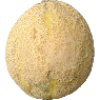

In [13]:
# display image of the 1st fruit

# extract binary image data from the dataframe
image_fruit = df_image.take(1)[0].asDict()['content']

# open binary
image_fruit = io.BytesIO(image_fruit)

# display image
image_fruit = Image.open(image_fruit)
image_fruit.show()

# CNN - Transfer Learning

## Model preparation

In [14]:
# load model ResNet50 without classifier layers and add a pooling layer
model = ResNet50(include_top=False, pooling='max')
model.summary()  # verify that the top layer is removed

# broadcast the weight of model to spark
bc_model_weights = sc.broadcast(model.get_weights())

2022-01-20 12:27:08.486706: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-20 12:27:08.486755: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-20 12:27:08.486780: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-1-230): /proc/driver/nvidia/version does not exist
2022-01-20 12:27:08.487053: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [15]:
def model_fn():
    """
    Returns a ResNet50 model with top layer removed and add a pooling layer and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False, pooling='max') 
    model.set_weights(bc_model_weights.value)
    return model

## Prepocessing - features extraction

In [16]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr) 

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [17]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    '''
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/opt/spark/python/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [18]:
# Apply featurization on the entire Spark DataFrame
df_features = df_image.repartition(16).select(col("path"), col("label"), featurize_udf("content").alias("features"))

In [19]:
df_features.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [20]:
# display dataframe with features
df_features.show()

2022-01-20 12:27:12.479430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 12:27:12.479482: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-20 12:27:15.605622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-20 12:27:15.605664: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-20 12:27:15.605687: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-1-230): /proc/driver/nvidia/version does not exist
2022-01-20 12:27:15.605889: I tensorflow/core/platform/cpu_fe

+--------------------+----------+--------------------+
|                path|     label|            features|
+--------------------+----------+--------------------+
|s3a://ah-oc-p8-im...|Cantaloupe|[1.3077774, 1.822...|
|s3a://ah-oc-p8-im...|Clementine|[2.4251144, 0.881...|
|s3a://ah-oc-p8-im...|Clementine|[7.4527235, 2.382...|
|s3a://ah-oc-p8-im...|       Fig|[6.1459804, 0.0, ...|
|s3a://ah-oc-p8-im...|     Mango|[7.8445435, 5.023...|
|s3a://ah-oc-p8-im...|     Mango|[8.001559, 4.4360...|
|s3a://ah-oc-p8-im...|   Avocado|[5.574579, 5.1665...|
|s3a://ah-oc-p8-im...|Cantaloupe|[0.042182803, 2.8...|
|s3a://ah-oc-p8-im...|Cantaloupe|[0.25075436, 2.86...|
|s3a://ah-oc-p8-im...|Clementine|[3.8205643, 0.548...|
|s3a://ah-oc-p8-im...|   Avocado|[6.5974684, 8.009...|
|s3a://ah-oc-p8-im...|   Avocado|[6.451435, 6.5305...|
|s3a://ah-oc-p8-im...|     Mango|[6.8060255, 4.554...|
|s3a://ah-oc-p8-im...|Cantaloupe|[1.0094798, 3.014...|
|s3a://ah-oc-p8-im...|Clementine|[5.1921005, 0.580...|
|s3a://ah-

In [21]:
# convert features array into vector
to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())
df_features = df_features.select(col("path"), col("label"), to_vector("features").alias("features"))

In [22]:
df_features.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)



# Dimension reduction - PCA

In [23]:
# define scaler to normalise fearture with Standardscaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                        withStd=True, withMean=True)

# define pca to use it in a pipeline, 
# after different test, k=12 to have 90% of variance
pca = PCA(k=12, inputCol="scaled_features", outputCol="pca_features")

# create a pipeline with step scaler and pca
pipeline = Pipeline (stages=[scaler,pca])
pca_model = pipeline.fit(df_features)
result =pca_model.transform(df_features)
result.show()

2022-01-20 12:27:31.820875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 12:27:31.821024: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-20 12:27:33.823381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 12:27:33.823433: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-20 12:27:35.638489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022

+--------------------+----------+--------------------+--------------------+--------------------+
|                path|     label|            features|     scaled_features|        pca_features|
+--------------------+----------+--------------------+--------------------+--------------------+
|s3a://ah-oc-p8-im...|Cantaloupe|[1.30777740478515...|[-1.4292252451844...|[12.7443452211791...|
|s3a://ah-oc-p8-im...|Clementine|[2.42511439323425...|[-0.9959915229977...|[10.0631664069113...|
|s3a://ah-oc-p8-im...|Clementine|[7.45272350311279...|[0.95340228647065...|[7.94852980630593...|
|s3a://ah-oc-p8-im...|       Fig|[6.14598035812377...|[0.44672864861730...|[-45.617166548517...|
|s3a://ah-oc-p8-im...|     Mango|[7.84454345703125...|[1.10532567110572...|[12.5721123419422...|
|s3a://ah-oc-p8-im...|     Mango|[8.00155925750732...|[1.16620662321382...|[12.2404752844572...|
|s3a://ah-oc-p8-im...|   Avocado|[5.57457876205444...|[0.22517468335192...|[14.1505952546842...|
|s3a://ah-oc-p8-im...|Cantalou

In [24]:
# Total variance explained by each of the selected components.
variance = pca_model.stages[-1].explainedVariance.cumsum()
variance

array([0.29243535, 0.49793628, 0.66114191, 0.76560603, 0.80918325,
       0.83091219, 0.84818718, 0.86139999, 0.87396581, 0.88596737,
       0.89730572, 0.90839399])

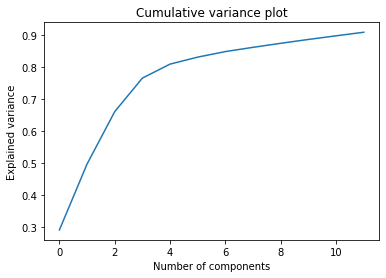

In [25]:
# Plot of the total variance explained by each of the selected components
plt.plot(variance)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Cumulative variance plot')

plt.show()

# Save Result

In [26]:
# save result of the PCA on the S3 bucket
result.select(col("label"),col("path"), col("pca_features")).write.parquet("s3a://ah-oc-p8-images/result.parquet",mode="overwrite")